# Guía TP 26 - Clasificación

El objetivo de esta práctica es la implementación de reglas de clasificación teniendo en
cuenta la selección de los parámetros de suviazado.

En un bosque de Bariloche hay dos variedades de hongos, que identificaremos como la
variedad I y variedad II. 

En el archivo hongos clasificados.txt encontrará n = 500 registros
correspondientes a la altura y variedad de cada uno los hongos examinados. 

A fin de clasificar
un nuevo hongo de este bosque, implementaremos la regla de Bayes, pero sin suponer que las
densidades condicionales involucradas en su cálculo pertenecen a una familia determinada.

En lo que sigue, llamaremos f 1 a la densidad de la altura de un hongo de la variedad I y f 0
a la densidad de la altura de un hongo de la variedad II.

## Data analisys

In [5]:
datos <- read.table('hongos_clasificados.txt', header=T)
head(datos)

Height,Variety
6.992,2
5.052,2
5.639,1
6.803,2
4.784,1
3.960,1


In [24]:
sum(datos$Variety == 1)

[1] 200

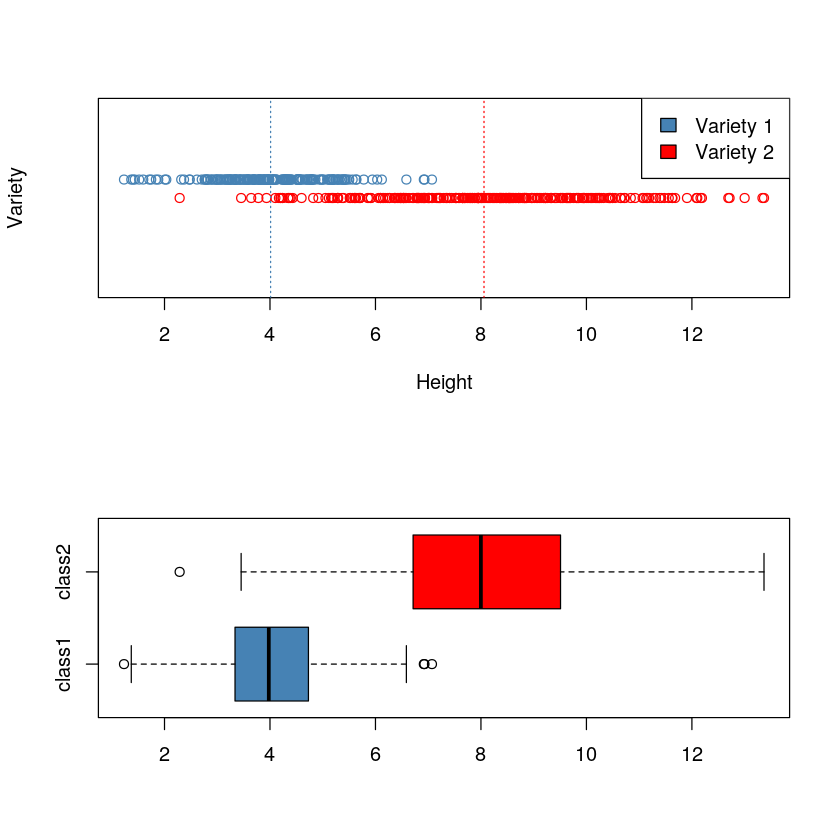

In [56]:
par(mfrow=c(2,1))

plot(datos[datos$Variety == 1,1], rep(1.2, sum(datos$Variety == 1)), col='steelblue',
     ylim=c(0,2), xlim=c(min(datos$Height), max(datos$Height)),
     xlab='Height', ylab='Variety', yaxt='n')
points(datos[datos$Variety == 2,1], rep(1, sum(datos$Variety == 2)), col='red')
abline(v=mean(datos[datos$Variety == 1,1]), col='steelblue', lty=3)
abline(v=mean(datos[datos$Variety == 2,1]), col='red', lty=3)
legend('topright', c('Variety 1', 'Variety 2'), fill=c('steelblue','red'))

classes <- list(class1=datos[datos$Variety == 1,1], class2=datos[datos$Variety == 2,1])
boxplot(classes, horizontal=T, col=c('steelblue', 'red'))


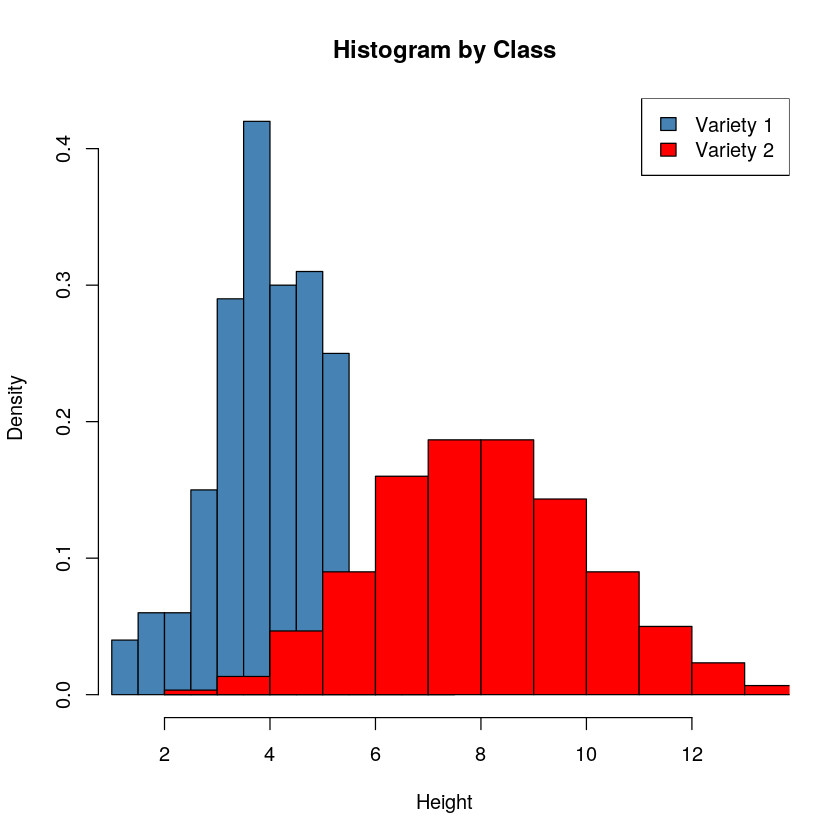

In [71]:
hist(datos[datos$Variety == 1,1], col='steelblue', prob=T, xlim=c(min(datos$Height), max(datos$Height)), main='Histogram by Class',
    xlab='Height')
hist(datos[datos$Variety == 2,1], col='red', prob=T, add=T)
legend('topright', c('Variety 1', 'Variety 2'), fill=c('steelblue','red'))


1. A partir de los alturas medidas en los hongos de variedad I estime la función de densidad
f 1 .

  Indique cómo determió la ventana y que núcleo usó.

  Llamemos $f_{1,h_1}$ a la estimación
resultante de la función de densidad $f_1$ .

Uso kernel normal ya que los histogramas se aproximan a una campana.

In [57]:
var1 <- datos[datos$Variety == 1,1]
var2 <- datos[datos$Variety == 2,1]

In [74]:
f1 <- density(var1)
f2 <- density(var2)

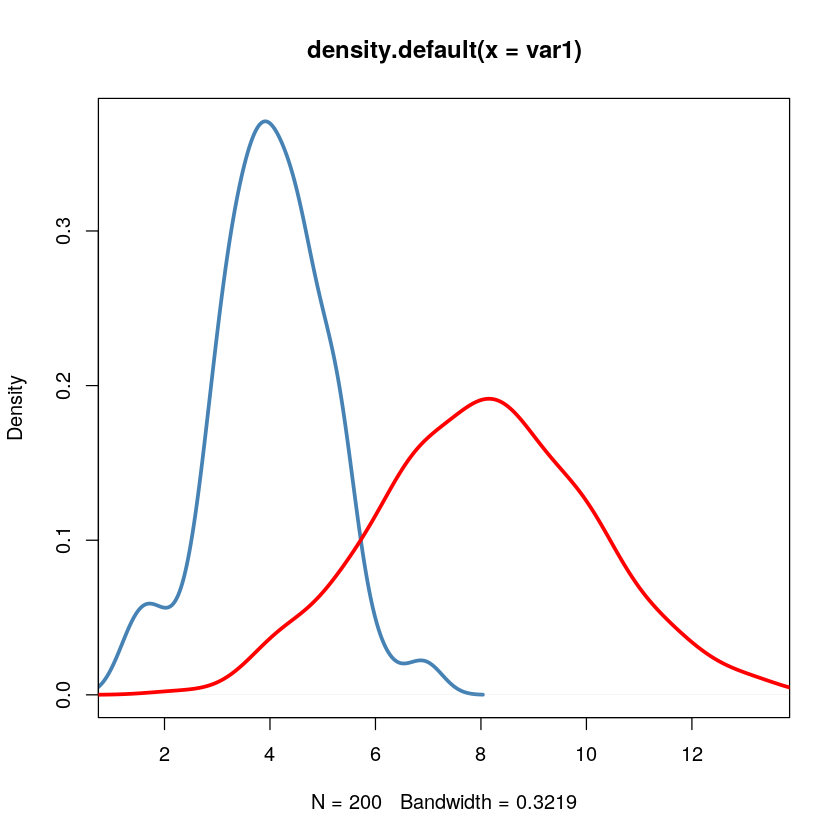

In [75]:
plot(f1, xlim=c(min(datos$Height), max(datos$Height)), col='steelblue', lwd=3)
lines(f2, col='red', lwd=3)

# $$\Large \mathcal 7.$$

Implemente una función `class.nopar` que dado un punto $x_{new}$ determine la **clase** a la que pertenece el nuevo individuo que tiene este valor en la covariable mediante la **regla plug–in de Bayes** $\widehat g$ basada en las estimaciones **no paramétricas** de las densidades $f_1$ y $f_0$ usando **núcleo gaussiano**.

Para ello entrar como input de la función implementada el punto $x_{new}$, los vectores de datos $X_{datos}$ e $Y_{datos}$ y las ventanas $h_1$ y $h_0$ : $\text{class.nopar}(x_{new}, X_{datos}, Y_{datos},h_1 ,h_0)$.

In [38]:
class.nopar <- function(xnew, X, Y, h1, h0){
    # Asume clase y=1 para variedad 1,
    #       clase y=0 para variedad 2
    n <- length(Y)
    # Estimación de priors
    prior1 <- sum(Y==1) / n
    prior0 <- sum(Y==0) / n

    # Estimación de densidades
    f1.h1 <- density(X[Y==1], bw=h1, kernel='gaussian', n=1, from=xnew, to=xnew)$y
    f0.h0 <- density(X[Y==0], bw=h0, kernel='gaussian', n=1, from=xnew, to=xnew)$y
    
    g_h0.h1 <- as.numeric(f1.h1 * prior1 >= f0.h0 * prior0)
    
    return(g_h0.h1)
}

In [39]:
class.nopar.12 <- function(xnew, X, Y, h1, h0){
    # Asume clase y=1 para variedad 1,
    #       clase y=2 para variedad 2
    # Convierto 2s en 0s
    Y.10 <- Y - 2 * (Y==2)
    g_h0.h1 <- class.nopar(xnew, X, Y10, h1, h0)
    if(g_h0.h1==0){
        return (2)
    }else{
        return (1)
    }
}

### Influencia de la ventana $h$ en la frontera de clasificación

Se grafica para cada $h$ en una grilla de valores

* **Ajuste de densidades** marginales con núcleo gaussiano
* **Valores puntuales** de *Height* separados por categoría
* ***Threshold*** de clasificación

> **Observar** cómo el límite de clasificación "se mueve" a la izquierda en favor de la clase 0, hasta clasificar todo como cero.
>
> Esto se debe a que a medida que aumentamos h, las distribuciónes estimadas se vuelven más parecidas, y el valor del prior gana más peso, considerando solo la proporción de valores en los datos.
>
> Demo de esto debajo de los gráficos.



In [33]:
datos <- read.table('hongos_clasificados.txt', header=T)

In [34]:
X <- datos[,1]
Y <- datos[,2]
Y.10 <- Y - 2 * (Y==2)

In [35]:
var1 <- datos[datos$Variety == 1,1]
var2 <- datos[datos$Variety == 2,1]

In [36]:
f1 <- density(var1)
f2 <- density(var2)

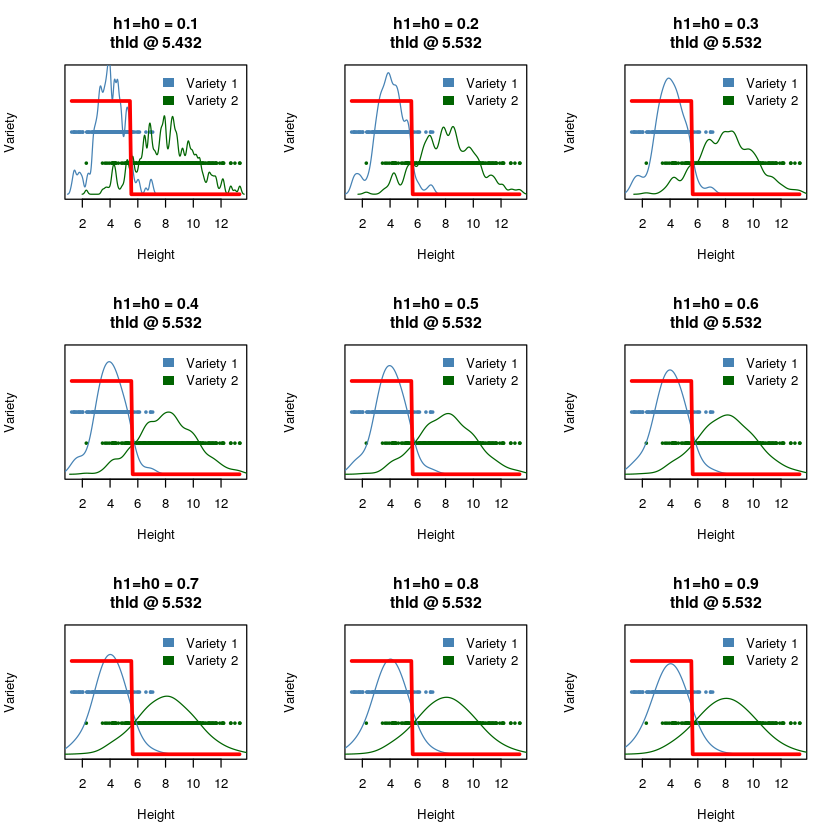

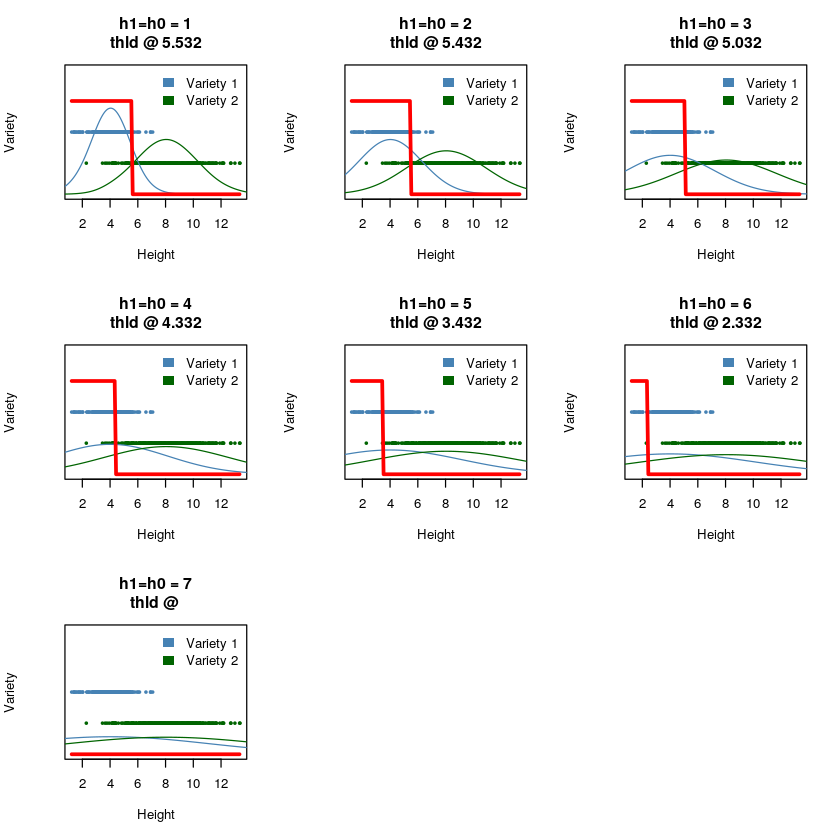

In [40]:
par(mfrow=c(3,3))
gridx <- seq(min(X), max(X), 0.1)
m <- length(gridx)
hs <- c(seq(0.1, 1, 0.1), seq(2,7))
for(h in hs){
    pred.class <- rep(NA, m)
    for(i in 1:m){
        xnew <- gridx[i]
        pred.class[i] <- class.nopar(xnew=xnew, X=X, Y=Y.10, h1=h, h0=h)
    }
    thld <- gridx[sum(pred.class[pred.class==1])]
    plot(datos[datos$Variety == 1,1], rep(0.2, sum(datos$Variety == 1)), col='steelblue',
     ylim=c(0,0.4), xlim=c(min(datos$Height), max(datos$Height)),
     xlab='Height', ylab='Variety', yaxt='n', main=paste0('h1=h0 = ',h,'\nthld @ ',thld), cex=0.6, pch=20)
    points(datos[datos$Variety == 2,1], rep(0.1, sum(datos$Variety == 2)), cex=0.6, pch=20,  col='darkgreen')
    lines(density(var1, bw=h), xlim=c(min(datos$Height), max(datos$Height)), col='steelblue', lwd=1)
    lines(density(var2, bw=h), col='darkgreen', lwd=1)
    
    lines(gridx, pred.class*0.3, col='red', lwd=3)
    legend('topright', c('Variety 1', 'Variety 2'), fill=c('steelblue','darkgreen','red'), bg=NA, border=NA, box.lty=0)

    
}

## Regla optima de Bayes - Caso binario

Sabemos que la condicion correspondiente a la categoría 1 es:

$$\Large g^{op}(x) = 1 \ \ \text{si:}\ \  f_1(x) \ \mathbb P(Y=1) > f_0(x) \  \mathbb P(Y=0)$$

Donde **si ambas densidades tienen valores muy similares para todo x**, la ecuación tiende a convertirse en $*$

$$\Large g^{op}(x) \stackrel{*}{=} 1 \ \ \text{si:}\ \ \mathbb P(Y=1) >  \mathbb P(Y=0)$$


Observar proporciones de los datos:

In [46]:
sum(Y==1)
sum(Y==2)

[1] 200

[1] 300

Por lo que siempre valdrá que el prior de $Y=1$ sea MENOR a $Y=0$, categorizando toda X como de la variedad 2 (clase 0)

---